In [3]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir = "krylov_data3"
all_files = os.listdir(data_dir)
assert "hubbard_exact_3.hdf5" in all_files
ev_files = [f for f in all_files if "eigenvalues" in f]
print(len(ev_files))

11


In [5]:
# Get the exact energy.
f_exact = h5py.File(data_dir + "/hubbard_exact_3.hdf5", "r")
energy_exact = np.min(f_exact["energies"])
print(f"Exact energy is {energy_exact}.")
f_exact.close()

Exact energy is (1.0717967697244912+0j).


In [6]:
dfs = []
for evf in ev_files:
    fname = data_dir + "/" + evf
    # Get the number of steps.
    f = h5py.File(fname, "r")
    steps = f["steps"][()]
    f.close()
    # Get the upper bound.
    # fname2 = fname.replace("eigenvalues", "bound")
    # bound_df = pd.read_hdf(fname2)
    # Get the dataframe with energy vs. d
    df = pd.read_hdf(fname, key="eigenvalues")
    df["error"] = abs(df["energy"] - energy_exact) / abs(energy_exact)
    df["steps"] = steps
    df.set_index("d")
    # df_concat = pd.concat([df, bound_df], axis=1)
    # dfs.append(df_concat)
    dfs.append(df)
df_total = pd.concat(dfs)
print(df_total)

     d           eps    energy  num_pos     error  steps
i                                                       
0    3  1.000000e-08  1.155197        3  0.077814     40
1    4  1.000000e-08  1.121213        4  0.046106     40
2    5  1.000000e-08  1.100667        5  0.026937     40
3    6  1.000000e-08  1.094194        6  0.020897     40
4    7  1.000000e-08  1.089019        6  0.016069     40
..  ..           ...       ...      ...       ...    ...
9   12  1.000000e-08  1.084563        8  0.011911     10
10  13  1.000000e-08  1.081899        9  0.009425     10
11  14  1.000000e-08  1.080137        9  0.007781     10
12  15  1.000000e-08  1.078892        9  0.006620     10
13  16  1.000000e-08  1.077785       10  0.005587     10

[154 rows x 6 columns]


In [7]:
df_small = df_total[df_total["d"] >= 20]
print(df_small)

Empty DataFrame
Columns: [d, eps, energy, num_pos, error, steps]
Index: []


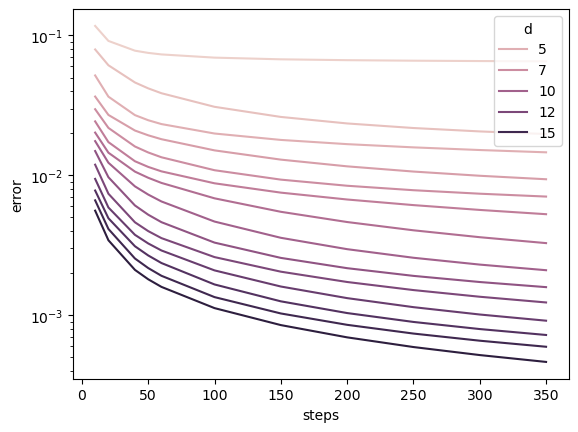

In [8]:
fig, ax = plt.subplots()
ax.set_yscale("log")
sns.lineplot(ax=ax, data=df_total, x="steps", y="error", hue="d")
plt.show()

ValueError: Could not interpret value `bound` for `y`. An entry with this name does not appear in `data`.

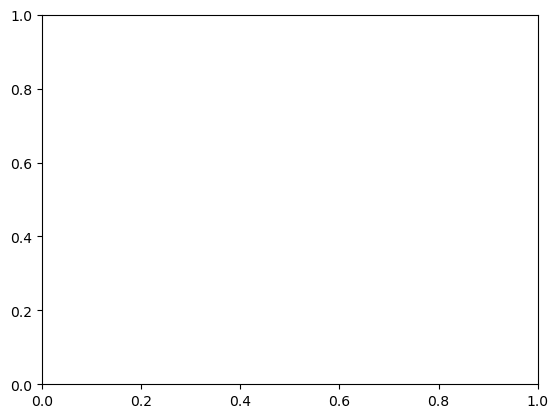

In [9]:
fig2, ax2 = plt.subplots()
ax.set_yscale("log")
sns.lineplot(ax=ax2, data=df_small, x="steps", y="bound", hue="d")
plt.show()

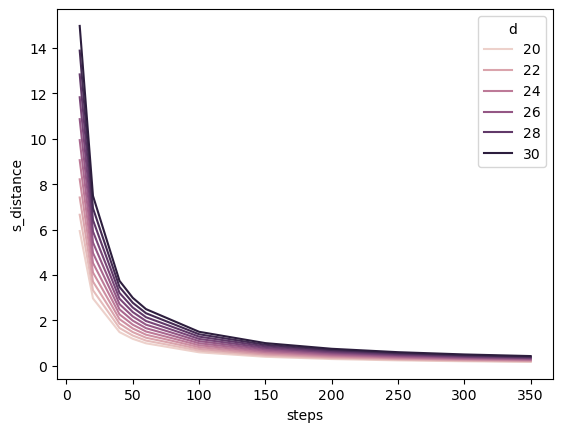

In [ ]:
fig3, ax3 = plt.subplots()
ax.set_yscale("log")
sns.lineplot(ax=ax3, data=df_small, x="steps", y="s_distance", hue="d")
plt.show()